In [1]:
# modified by Gautam Banuru: Implementation of Genetic Algorithm
# modified from Eric Stoltz via https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35
#import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
from __future__ import division
import numpy as np
import pandas as pd
import operator
import random
import math
import matplotlib.pyplot as plt
import time

class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        #xDis = abs(self.x - city.x)
        #yDis = abs(self.y - city.y)
        #distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        #return distance
        
        #above distance for general points 
        #below distance for latlong coordinates
        
        R = 6371 # Radius of the earth in km
        dLat = (self.y-city.y) * (3.14159/180) 
        dLon = (self.x-city.x) * (3.14159/180) 
        a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(city.y * (3.14159/180)) * math.cos(self.y * (3.14159/180)) * math.sin(dLon/2) * math.sin(dLon/2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a)); 
        distance = R * c; # Distance in km
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"
    
    def __getitem__(self, index):
        if index == 0:
            return int(self.x)
        if index == 1:
            return int(self.y)
    
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness


def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool


def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

Initial distance: 429848.805661
Final distance: 288832.387704
Time Taken: 53.7651438713 seconds
Final Path: [(-123.450732502,58.6273727087), (-111.046443612,39.923492634), (45.3639843426,146.592390578), (65.7014232836,150.071968776), (126.419096698,77.0040801093), (-82.692774889,74.4532214595), (150.759486099,108.546430036), (-74.9671858657,25.7070646884), (-66.9167663273,50.9975623809), (57.5942963905,116.104389258), (-155.787791684,97.6731613105), (167.137217932,-41.2379235057), (-125.52012277,-84.6716432585), (63.0939460401,-75.1474981605), (84.2156365219,-49.6886179211), (142.742310071,-58.7303046786), (136.003789443,-69.8665968292), (-113.879542007,-107.853639333), (-73.4587351183,-110.208083639), (134.289553876,-79.9899657368), (19.9644863487,-172.545874), (170.246447567,31.3130818388), (-158.794221724,82.2264065712), (34.7224913525,179.047120374), (153.2054855,175.718562663), (145.348423141,169.193811466), (-101.022360394,-20.8806341654), (54.6387056107,-162.904145175), (86.1599

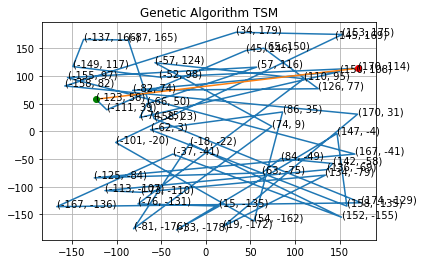

In [2]:
#size 10
cityList = [City(77.10361227774376, -78.2479676195133),
City(159.59106390274815, -80.46610237450903),
City(-163.9877816988646, -143.06184377788446),
City(-146.48151550586763, 120.85370663409276),
City(-139.3811591251711, 107.54213632508396),
City(-116.08229784024806, -163.6395189212772),
City(77.48664305393612, 172.29557162660524),
City(170.30359916271647, -49.226215634726344),
City(-141.87502704162554, 104.87045243952696),
City(-162.80324819155368, 179.5785233709624)]

#size 20
'''cityList = [City(53.50702510929551, -72.75705275395967),
City(-50.502073588142736, -45.95600408878141),
City(-100.13341944532675, 169.65334121764204),
City(-113.96224872252505, 70.62442854580269),
City(-20.812658686879217, -0.16899089664684652),
City(-81.53442263344853, -56.77758619750064),
City(-81.31438830362507, 159.56589906372966),
City(113.02758695845915, -2.183793384752022),
City(70.54567943044583, 132.78372388534865),
City(-8.946862127342143, 95.34642690128356),
City(148.90342280768397, 176.72584584513385),
City(-162.95240986498501, -156.74263932956927),
City(-107.57610299479097, 175.32913931401896),
City(71.13120068096572, 166.90929621336198),
City(20.76736298105257, -21.856881455310287),
City(40.751400936039516, 126.22629682899884),
City(60.183859885033314, -17.38770976010585),
City(-27.519864950509174, 110.63070183319121),
City(-33.16433087437764, 17.96819804463709),
City(157.97512088320167, -115.50409727842604)]'''

#size 30
'''cityList = [City(-150.8849621883804, -35.23031546062032),
City(-88.13198201331278, 118.9712007648867),
City(-72.03340557666237, 47.42949656049481),
City(89.16266564927884, -28.306112504935527),
City(-10.178221049680559, 59.85459957284701),
City(-31.357005813514263, 14.538789816888396),
City(88.22948893850202, 50.65150341132767),
City(-124.19157918505181, 0.34670126471360163),
City(9.406208165849193, 48.5150894926376),
City(116.66935863747892, 109.67962927272004),
City(43.03191705316786, 59.64437525833554),
City(56.12514533226883, 123.61955261729065),
City(70.37422784031858, -2.83399976855884),
City(147.26085207468674, -136.98669903825427),
City(156.43021334726495, -8.947492833852039),
City(-16.12059110917201, -88.54007357189316),
City(-150.55035167294537, 73.43640848071138),
City(-166.18118734571553, -163.37464909119757),
City(20.924831437480265, -22.778496822005906),
City(74.94732391508353, -155.36785353599822),
City(8.620825276856323, 109.56348195911772),
City(65.81070962584812, -12.60178818530116),
City(-17.628681815332783, 138.49998912836202),
City(71.70085316006734, -34.603963965355376),
City(-139.03624880334291, -69.18629929935364),
City(108.37650954413658, -18.67435408664096),
City(19.656426267025324, 108.76691272701544),
City(-175.72587740383148, -71.66710468777909),
City(77.98906920508261, -43.90709671281178),
City(-124.82203370242024, 10.049309964991636)]'''

#Size 40
'''cityList = [City(18.1731062370458, 29.428322919913114),
City(58.90813677201689, 147.22372938159282),
City(151.523395024879, 58.649040902011535),
City(130.07431230052276, 46.65698910932545),
City(107.96873683667945, -89.60157673729283),
City(77.13900097126646, 164.70603037660874),
City(-172.28604427212844, 121.49435197103509),
City(10.22153960003726, 41.28446477326696),
City(167.5126236138645, 58.47434003779861),
City(129.11848314866432, 54.56718435901465),
City(2.2610914773032675, -20.177261506510888),
City(-123.67357929027725, -106.38821005580388),
City(47.16842055503179, 162.45239035029613),
City(139.00194299142856, 9.908246528155644),
City(177.22774946212223, 50.51375056079095),
City(122.20099737557285, 30.065410516870855),
City(179.5465235707124, -81.48614883895729),
City(127.1759239880979, -121.8033626411083),
City(-62.10255076602331, -107.94482856188492),
City(-90.39204113192555, -68.17075431671324),
City(63.901677204752474, 19.71501019539403),
City(35.853089852355225, -94.70615877423661),
City(-102.99141197184397, -56.52695672753444),
City(-167.32773592887406, 75.37489695927687),
City(170.40529544713587, -29.526495380235872),
City(102.85658845637812, 153.1833570237145),
City(-150.8430975817798, 102.04079565848787),
City(-107.34733894446427, -21.734029568091557),
City(-16.164590730735938, 92.70160341982944),
City(57.83239189953903, 95.71983136203892),
City(-11.539338181312218, -33.154737943100685),
City(146.78480890728213, -138.7705294991884),
City(81.41259838720549, 74.28084164532689),
City(41.922731906335514, -27.25077285560343),
City(89.00357957286656, 66.91284308057263),
City(91.92415659386495, -129.13622854985437),
City(19.108814644750566, 158.78386420579994),
City(-107.760465655251, -166.39430373571568),
City(-7.774876561024627, -159.32775470982588),
City(-65.82594184058495, 11.925007487207836)]'''

#Size 50
'''cityList = [City(150.75948609936972, 108.54643003555645),
City(86.15995871346888, 35.693201175667014),
City(-113.87954200724684, -107.85363933284452),
City(-58.348358734390544, 23.853189386751268),
City(152.11445854940354, -155.1536995379939),
City(170.24644756669971, 31.31308183882382),
City(136.00378944298808, -69.86659682920101),
City(-81.64137114084305, -176.30172855232607),
City(84.2156365218982, -49.68861792109885),
City(147.52239577423114, -4.514497221446334),
City(126.41909669769149, 77.00408010926031),
City(-66.91676632726582, 50.99756238086272),
City(174.21915586804766, -129.9355170519845),
City(-37.733861818110796, -41.24661318459454),
City(-158.79422172410617, 82.22640657119149),
City(19.964486348653054, -172.54587400039887),
City(-73.45873511827476, -110.20808363896109),
City(-57.02424634226334, 124.91839321305719),
City(-76.20612870647403, -131.13308911963287),
City(-111.04644361162222, 39.92349263401772),
City(65.70142328359495, 150.071968775997),
City(-62.630609804830826, 3.2777441710481128),
City(-123.45073250186124, 58.62737270865364),
City(57.59429639049429, 116.10438925771155),
City(45.363984342595415, 146.59239057846378),
City(-167.67286563372411, -136.8320909923371),
City(142.74231007081136, -58.730304678612086),
City(63.0939460401209, -75.14749816047049),
City(-33.18184732699004, -178.2729948484922),
City(-87.78593380924472, 165.83255417589498),
City(134.28955387638177, -79.9899657367843),
City(170.90960776943507, 114.92543337566804),
City(-101.02236039417005, -20.88063416539856),
City(74.0138920415823, 9.66505885865891),
City(-155.7877916840555, 97.67316131053394),
City(-82.69277488903793, 74.45322145953241),
City(-149.58244125035478, 117.11423947201712),
City(110.35663856084255, 95.43535086689297),
City(15.936976360766067, -135.96814720323974),
City(34.72249135251721, 179.0471203737224),
City(158.05981113824595, -135.66377026914455),
City(153.2054854995821, 175.7185626626972),
City(-137.16963266582047, 166.02246560222375),
City(145.34842314069704, 169.19381146649204),
City(-18.52261924596891, -22.025139485951485),
City(-74.96718586570711, 25.707064688389664),
City(167.137217932417, -41.23792350570602),
City(-125.52012277042854, -84.67164325851664),
City(54.638705610676, -162.90414517519937),
City(-52.04713206165974, 98.62357278432432)]'''



#cityList = []
#update with real coordinates
#for i in range(0,25):
#    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))
    
# 1st no plot, 2nd plot   
start = time.time()
finalpts = geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.015, generations=450)
print("Time Taken: {} seconds".format(time.time() - start))
print('Final Path: {}'.format(finalpts))
#geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)


fig = plt.figure()
ax = fig.add_subplot(111)
allpath = [] #put ordered tuple coordinates here

for t in range(len(finalpts)):
    allpath.append(finalpts[t])

Xf = [x[0] for x in allpath]
Yf = [y[1] for y in allpath]
print('Entire Path: {}\n'.format(allpath))
print('X coord: {}\n'.format(Xf))
print('Y coord: {}\n'.format(Yf))

plt.plot(Xf,Yf) #most points
plt.plot([Xf[-1],Xf[0]], [Yf[-1], Yf[0]]) #last stretch
plt.plot(Xf[-1], Yf[-1], 'ro') #end point before finish
plt.plot(Xf[0], Yf[0], 'go') #start point

for xy in zip(Xf, Yf):                                     # <--
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data') # <--
plt.title('Genetic Algorithm TSM')
plt.grid()
plt.show()